In [1]:
import os
import tensorflow as tf
import numpy as np
from scipy import misc
import random
import math
import face_recognition
from skimage import transform
import os.path
import urllib.request
import time
import requests
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [2]:
%matplotlib inline

## Set global variables

In [3]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
DENSE_SIZE = 90

### Set up variables and download helpers

In [4]:
START_MONTH = 9
START_DATE = 11
START_SLOT = 0

DESIRED_X = 32
DESIRED_Y = 21
DESIRED_SIZE = 24

NAMES_PER_FILE = 100
TEMP_FILENAME = "temp.png"
monthOn = 0
dayOn = 0
daysInMonth = [31,29,31,30,31,30,31,31,30,31,30,31]
monthNames = ['january','february','march','april','may','june','july','august','september','october','november','december']

def getAvg(face, landmark):
    cum = np.zeros((2))
    for point in face[landmark]:
        cum[0] += point[0]
        cum[1] += point[1]
    return cum/len(face[landmark])

def getNorm(a):
    return (a-np.mean(a))/np.std(a)


## Download all the data

In [ ]:
imageCounter = 10267
for monthOn in range(START_MONTH,12):
    thisStartDate = 1
    if monthOn == START_MONTH:
        thisStartDate = START_DATE
    for dayOn in range(thisStartDate,daysInMonth[monthOn]+1):
        response = urllib.request.urlopen("https://www.famousbirthdays.com/"+monthNames[monthOn]+str(dayOn)+".html")
        pageSource = response.read().splitlines()
        lineOn = 0
        while str(pageSource[lineOn]) != "b'<div class=\"container people-list\">'":
            lineOn += 1

        thisStartSlot = 0
        if monthOn == START_MONTH and dayOn == START_DATE:
            thisStartSlot = START_SLOT
        for slotOn in range(0,48):
            while "class=\"face person-item\"" not in str(pageSource[lineOn]):
                lineOn += 1
            iul = str(pageSource[lineOn])
            pnl = str(pageSource[lineOn+4])
            imageURL = iul[iul.index("background: url(")+16:iul.index(") no-repeat center center")]
            personName = ""
            age = ""
            pnl_s = 2
            if pnl[pnl_s] == ' ':
               pnl_s += 1
            if "," in pnl:
                personName = pnl[pnl_s:pnl.index(",")]
                age = pnl[pnl.index(",")+2:-1]
            else:
                personName = pnl[pnl_s:pnl.index("(")-1]
                age = pnl[pnl.index("(")+1:pnl.index(")")]

            if slotOn < thisStartSlot or imageURL == 'https://www.famousbirthdays.com/faces/large-default.jpg' or personName == "Ronan Domingo"  or personName == "Glam And Gore" or personName == "Edith Piaf" or personName == "Lexi Marie":
                print(personName+" SKIPPED!")
            else:
            
                img_data = requests.get(imageURL).content
                with open("temp.png", 'wb') as handler:
                    handler.write(img_data)
                
                image_face_info = face_recognition.load_image_file(TEMP_FILENAME)
                face_landmarks = face_recognition.face_landmarks(image_face_info)

                image_numpy = misc.imread(TEMP_FILENAME)
                colorAmount = 0
                if len(image_numpy.shape) == 3:
                    nR = getNorm(image_numpy[:,:,0])
                    nG = getNorm(image_numpy[:,:,1])
                    nB = getNorm(image_numpy[:,:,2])
                    colorAmount = np.mean(np.square(nR-nG))+np.mean(np.square(nR-nB))+np.mean(np.square(nG-nB))
                if len(face_landmarks) == 1 and colorAmount >= 0.04: # We need there to only be one face in the image, AND we need it to be a colored image.
                    leftEyePosition = getAvg(face_landmarks[0],'left_eye')
                    rightEyePosition = getAvg(face_landmarks[0],'right_eye')
                    nosePosition = getAvg(face_landmarks[0],'nose_tip')
                    mouthPosition = getAvg(face_landmarks[0],'bottom_lip')
            
                    centralPosition = (leftEyePosition+rightEyePosition)/2
            
                    faceWidth = np.linalg.norm(leftEyePosition-rightEyePosition)
                    faceHeight = np.linalg.norm(centralPosition-mouthPosition)
                    if faceWidth >= faceHeight*0.7 and faceWidth <= faceHeight*1.5:

                        faceSize = (faceWidth+faceHeight)/2
            
                        toScaleFactor = faceSize/DESIRED_SIZE
                        toXShift = (centralPosition[0])
                        toYShift = (centralPosition[1])
                        toRotateFactor = np.arctan2(rightEyePosition[1]-leftEyePosition[1],rightEyePosition[0]-leftEyePosition[0])
            
                        rotateT = transform.SimilarityTransform(scale=toScaleFactor,rotation=toRotateFactor,translation=(toXShift,toYShift))
                        moveT = transform.SimilarityTransform(scale=1,rotation=0,translation=(-DESIRED_X,-DESIRED_Y))

                        outputArr = transform.warp(image=image_numpy,inverse_map=(moveT+rotateT))[0:IMAGE_HEIGHT,0:IMAGE_WIDTH]

                        misc.imsave("../data/dataFace"+str(imageCounter)+".png",outputArr)
                        if imageCounter%NAMES_PER_FILE == 0:
                            f = open("../names/name"+str(imageCounter)+".txt","w+")
                        fame = str(slotOn)
                        if monthOn == 1 and dayOn == 29:
                            fame *= 4
                        f.write(personName+","+fame+","+age+"\n")
                        if imageCounter%NAMES_PER_FILE == (NAMES_PER_FILE-1):
                            f.close()
                        print("DAY "+monthNames[monthOn]+" "+str(dayOn)+":  I just used person "+personName+" to create image number "+str(imageCounter))
                        imageCounter += 1
                time.sleep(0.5)
            lineOn += 1


### Store images count

In [5]:
images_count = len(os.listdir('../data/'))

### Setup helper functions

In [6]:
def CreateAutoEncoder():
    input_img = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # adapt this if using `channels_first` image data format

    x = Conv2D(40, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(80, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(DENSE_SIZE, activation='relu')(x)

    y = Dense(3200, activation='relu')(encoded)
    y = Reshape([4,4,200])(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(150, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(80, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(40, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(15, (3, 3), activation='relu', padding='same')(y)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(y)

    autoencoder = Model(input_img, decoded)
    optimizer = tf.keras.optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')
    return autoencoder


In [7]:
def WriteOutputFileResult(epoch):
    if epoch%10!=0:
        return
    
    imageIndex = np.random.randint(images_count)
    output = autoencoder.predict(batch_data[imageIndex].reshape(1,64,64,3))
    exampleImage = np.empty([IMAGE_HEIGHT*2,IMAGE_WIDTH,3])
    exampleImage[0:IMAGE_HEIGHT,0:IMAGE_WIDTH,0:3] = batch_data[imageIndex,0:IMAGE_HEIGHT,0:IMAGE_WIDTH,0:3]
    exampleImage[IMAGE_HEIGHT:IMAGE_HEIGHT*2,0:IMAGE_WIDTH,0:3] = output[0,0:IMAGE_HEIGHT,0:IMAGE_WIDTH,0:3]
    exampleImage = np.clip(exampleImage, 0, 1)
    misc.imsave('../modelExamples/encoder'+str(epoch)+'.png',exampleImage)

    save_path='../models/keras.h5'
    autoencoder.save(save_path)
    print("MODEL SAVED: "+str(save_path))

## Train autoencoder

In [9]:
#autoencoder = load_model('../models/keras.h5', custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform})

In [ ]:
modelPath = '../models/keras.h5'
if os.path.isfile(modelPath):
    print('Loading existing model')
    autoencoder = load_model('../models/keras.h5', custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform})
else:
    print('Creating new model')
    autoencoder = CreateAutoEncoder()
batch_data = np.empty([images_count,IMAGE_HEIGHT,IMAGE_WIDTH,3])
for example in range(images_count):
    imageIndex = example# +  int(math.floor(random.randrange(images_count)))
    imagio = misc.imread('../data/dataFace'+str(imageIndex)+'.png')
    batch_data[example] = imagio[:,:,0:3]/255.0
autoencoder.fit(batch_data, batch_data,
    epochs=1000000,
    batch_size=200,
    shuffle=True,
    #validation_data=(batch_data, batch_data),
    callbacks=[
        #tf.keras.callbacks.ModelCheckpoint('../models/keras.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
        tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: WriteOutputFileResult(epoch))
    ])



## Tear apart encoder and decoder

In [10]:
[layer.name for layer in autoencoder.layers]

['input_5',
 'conv2d_18',
 'max_pooling2d_8',
 'conv2d_19',
 'max_pooling2d_9',
 'conv2d_20',
 'max_pooling2d_10',
 'conv2d_21',
 'max_pooling2d_11',
 'flatten_2',
 'dense_4',
 'dense_5',
 'reshape_2',
 'up_sampling2d_8',
 'conv2d_22',
 'up_sampling2d_9',
 'conv2d_23',
 'up_sampling2d_10',
 'conv2d_24',
 'up_sampling2d_11',
 'conv2d_25',
 'conv2d_26']

In [11]:
encoder = Sequential()
for i in range(0,11):
    encoder.add(autoencoder.layers[i])
encoder.build()

# this looks redundant, but it's needed to properly export
# model to tensorflowJS format that will be possible to use
# in the browser
decoder = Sequential()
for i in range(11,len(autoencoder.layers)):
    decoder.add(autoencoder.layers[i])
decoder.build(input_shape=(None, 90))

dec_input = Input(shape=(90,))
dec_output = decoder.layers[0](dec_input)
for i in range(1,len(decoder.layers)):
    decoder.layers[i].trainable=False
    dec_output = decoder.layers[i](dec_output)
decoder = Model(dec_input, dec_output)
decoder.summary()
decoder.compile(optimizer='adagrad', loss='binary_crossentropy')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3200)              291200    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 200)         0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 8, 8, 200)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 150)         270150    
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 16, 16, 150)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 80)        108080    
__________

In [12]:
def getEncodedImage(index):
    image = misc.imread('../data/dataFace'+str(index)+'.png')
    image = image[:,:,0:3]/255.0
    return image

### Preview random image to be encoded

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


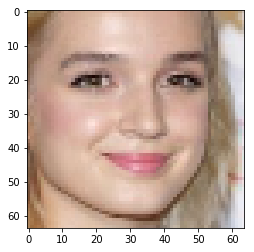

In [13]:
randIndex = 0 #np.random.randint(0, images_count)
image = getEncodedImage(randIndex)
plt.imshow(image)

In [14]:
encoded = encoder.predict(image.reshape([-1, image.shape[0], image.shape[1], image.shape[2]]))
print('Encoded image:\n' ,encoded[0])

Encoded image:
 [1.185619   0.         0.         0.         0.         1.2334177
 0.         0.9048997  0.6996028  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.6473769  0.5568536
 1.3302875  0.         0.         0.         0.         0.
 0.         0.         0.47524002 0.4830742  0.         0.
 0.         0.         1.3309177  0.         0.         0.
 0.         0.71094865 0.         1.1644648  0.         0.
 0.         0.         1.1319467  0.         0.72256625 0.
 0.         0.         0.8128762  0.         0.         0.
 2.5420327  0.         0.         0.         0.         0.
 0.         0.         0.77186465 0.71098304 0.         0.9035849
 0.         0.         0.9000814  0.         0.         0.6302799
 0.         0.         0.         0.80187684 1.3965821  0.
 0.5903191  0.66276574 0.         1.3100547  0.         0.        ]


In [15]:
decoded = decoder.predict(encoded)

### Recreate image from encoded state

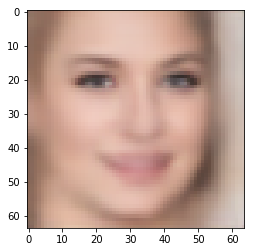

In [16]:
plt.imshow(decoded[0])

## Create dataframe to inspect all encoded images together

In [17]:
import pandas as pd

In [18]:
all_rows = []
for i in range(images_count):
    image = getEncodedImage(i)
    encoded_internal = encoder.predict(image.reshape([-1, image.shape[0], image.shape[1], image.shape[2]]))[0]
    all_rows.append(encoded_internal)
df = pd.DataFrame(all_rows)
df.describe()
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
count,13228.000000,13228.0,13228.0,13228.0,13228.0,13228.000000,13228.0,13228.000000,13228.000000,13228.0,...,13228.0,13228.000000,13228.000000,13228.0,13228.000000,13228.000000,13228.0,13228.000000,13228.0,13228.0
mean,1.169773,0.0,0.0,0.0,0.0,1.092326,0.0,0.928655,1.248597,0.0,...,0.0,1.299901,1.110633,0.0,1.122023,0.993700,0.0,1.001647,0.0,0.0
std,0.507703,0.0,0.0,0.0,0.0,0.526721,0.0,0.458489,0.646425,0.0,...,0.0,0.575462,0.533455,0.0,0.520116,0.511088,0.0,0.452328,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
25%,0.825467,0.0,0.0,0.0,0.0,0.722806,0.0,0.610363,0.806668,0.0,...,0.0,0.905026,0.746083,0.0,0.763233,0.647264,0.0,0.693705,0.0,0.0
50%,1.136732,0.0,0.0,0.0,0.0,1.045580,0.0,0.888308,1.177368,0.0,...,0.0,1.244806,1.052875,0.0,1.097230,0.940482,0.0,0.981564,0.0,0.0
75%,1.480820,0.0,0.0,0.0,0.0,1.398070,0.0,1.212442,1.593209,0.0,...,0.0,1.633125,1.406588,0.0,1.452765,1.277784,0.0,1.283858,0.0,0.0
max,4.195548,0.0,0.0,0.0,0.0,3.896302,0.0,3.248031,5.779648,0.0,...,0.0,5.780103,4.497020,0.0,4.554452,3.966504,0.0,3.405080,0.0,0.0


## Save mean from encodings to file

In [19]:

mean = df.mean().values.tolist()

text_file = open("../models/mean.json", "w")
text_file.write(json.dumps(mean))
text_file.close()

## Filter out columns all containing zeros

In [20]:
m2 = df.loc[:, (df != 0).any(axis=0)]

In [21]:
m2.describe()

,0,5,7,8,14,22,23,24,32,33,...,68,69,71,74,77,81,82,84,85,87
count,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,...,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000,13228.000000
mean,1.169773,1.092326,0.928655,1.248597,0.104677,0.711186,1.204581,1.183014,1.059289,1.004621,...,0.982228,0.992269,1.119543,1.159865,1.072564,1.299901,1.110633,1.122023,0.993700,1.001647
std,0.507703,0.526721,0.458489,0.646425,0.332655,0.414327,0.633563,0.551203,0.579689,0.485516,...,0.617274,0.476432,0.509124,0.507343,0.486134,0.575462,0.533455,0.520116,0.511088,0.452328
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.825467,0.722806,0.610363,0.806668,0.000000,0.427792,0.765810,0.799082,0.654399,0.666010,...,0.543316,0.655278,0.775174,0.820690,0.746425,0.905026,0.746083,0.763233,0.647264,0.693705
50%,1.136732,1.045580,0.888308,1.177368,0.000000,0.653103,1.107011,1.168465,0.991160,0.959009,...,0.880096,0.951835,1.075003,1.131613,1.034778,1.244806,1.052875,1.097230,0.940482,0.981564
75%,1.480820,1.398070,1.212442,1.593209,0.000000,0.926202,1.543575,1.530779,1.385798,1.305935,...,1.304499,1.281445,1.418695,1.469621,1.355841,1.633125,1.406588,1.452765,1.277784,1.283858
max,4.195548,3.896302,3.248031,5.779648,5.110476,3.027106,5.859632,4.180594,4.852405,3.474011,...,5.486449,3.541837,4.984731,4.066056,4.151653,5.780103,4.497020,4.554452,3.966504,3.405080


In [22]:
pca_columns = len(m2.columns)

### This number shows how many principal components are needed
#### We can take only non-zero columns from our encodings table
This will allow to use fewer components

In [23]:
pca_columns

27

## Manual PCA

In [24]:
np_all_rows = np.asarray(all_rows)

pca = PCA(n_components=pca_columns)
pca.fit(np_all_rows)
values = np.sqrt(pca.explained_variance_)
vectors = pca.components_
eigenvectorInverses = np.linalg.pinv(vectors)

json_vectors = json.dumps(vectors.tolist())
json_values = json.dumps(values.tolist())



text_file = open("../models/eigenVectors.json", "w")
text_file.write(json_vectors)
text_file.close()

text_file = open("../models/eigenValues.json", "w")
text_file.write(json_values)
text_file.close()


## Load data as it will be loaded by tensorflowJS in the browser

In [25]:
with open('../models/eigenVectors.json') as f:
    eigenVectors = np.asarray(json.load(f))
with open('../models/eigenValues.json') as f:
    eigenValues = np.asarray(json.load(f))
with open('../models/mean.json') as f:
    meanData = np.asarray(json.load(f))

In [26]:
all_rows_pca = []
for row in np_all_rows:
    all_rows_pca.append(np.matmul(row - meanData, eigenvectorInverses) / eigenValues)

all_rows_pca = np.asarray(all_rows_pca)

sliders_min = all_rows_pca.min(axis=0)
sliders_max = all_rows_pca.max(axis=0)

json_sliders_min = json.dumps(sliders_min.tolist())
json_sliders_max = json.dumps(sliders_max.tolist())

text_file = open("../models/slidersMin.json", "w")
text_file.write(json_sliders_min)
text_file.close()

text_file = open("../models/slidersMax.json", "w")
text_file.write(json_sliders_max)
text_file.close()

In [27]:
traits = encoded[0] - meanData
image_pca = np.matmul(traits, eigenvectorInverses) / eigenValues

In [28]:
recovered_from_pca = meanData.copy()
for i in range(pca_columns):
    recovered_from_pca += all_rows_pca[0][i] * eigenValues[i] * eigenVectors[i]
    #recovered_from_pca += image_pca[i] * eigenValues[i] * eigenVectors[i]

In [29]:
eigenVectors.shape

(27, 90)

In [30]:
image_pca

array([-1.19065424,  1.22428321, -0.45107317,  1.1642318 , -0.30058592,
        0.45079171, -0.25804107,  0.10516445,  1.22633373, -0.0741795 ,
       -0.49508225,  0.26210224,  0.4498657 ,  0.30517044, -0.69219232,
        0.42681913, -0.16882188, -0.60252219, -0.15343942, -0.43781948,
       -0.79690091,  0.79182878,  0.49240054,  0.66863203, -0.01272827,
        0.35885138,  0.58326572])

In [31]:
recovered_from_pca

array([ 1.18561903e+00,  2.64457515e-08, -1.68802171e-08,  1.28350497e-08,
        2.72434505e-08,  1.23341776e+00, -1.23195111e-08,  9.04899712e-01,
        6.99602747e-01, -2.33297614e-10,  1.96710553e-08, -3.46800271e-09,
       -9.41201264e-09, -1.19871840e-08,  7.71361242e-09,  1.22357995e-08,
       -5.28319192e-09,  2.67190366e-08, -3.48354143e-09, -1.66263259e-08,
        4.66559320e-09,  1.31952688e-08,  6.47376855e-01,  5.56853514e-01,
        1.33028745e+00, -1.06962093e-14,  7.55920906e-15, -2.15480827e-21,
        4.68931670e-21,  4.65137769e-21,  5.21222594e-21,  2.40497191e-21,
        4.75239989e-01,  4.83074161e-01,  1.21190660e-21,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.33091771e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.10948656e-01,
        0.00000000e+00,  1.16446482e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.13194665e+00,  0.00000000e+00,
        7.22566246e-01,  

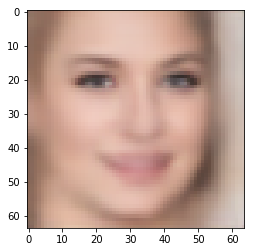

In [32]:
decoded = decoder.predict(recovered_from_pca.reshape(1,DENSE_SIZE))
plt.imshow(decoded[0])

### Save all images as encodings in json file

In [33]:
json_all_rows_pca = json.dumps(all_rows_pca.tolist())

text_file = open("../models/facesPca.json", "w")
text_file.write(json_all_rows_pca)
text_file.close()

## Save decoder part

In [34]:
#tf.keras.models.save_model(decoder, '../models/decoder.h5')
decoder.save('../models/decoder.h5')

In [35]:
loaded = load_model('../models/decoder.h5')

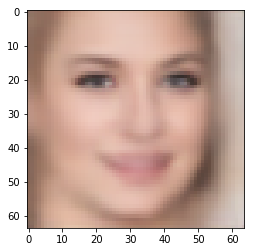

In [36]:
res = loaded.predict(encoded)
plt.imshow(res[0])